In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Frase base (puedes extenderla si quieres)
text = "I like to eat pizza and I like to eat pasta"

# Tokenización simple por palabras
words = text.lower().split()
vocab = sorted(set(words))  # vocabulario único
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

# Secuencia de entrenamiento: input y target
input_seq = [word2idx[w] for w in words[:-1]]   # todas menos la última
target_seq = [word2idx[w] for w in words[1:]]   # todas menos la primera

print("Vocabulario:", vocab)
print("Input indices: ", input_seq)
print("Target indices:", target_seq)

Vocabulario: ['and', 'eat', 'i', 'like', 'pasta', 'pizza', 'to']
Input indices:  [2, 3, 6, 1, 5, 0, 2, 3, 6, 1]
Target indices: [3, 6, 1, 5, 0, 2, 3, 6, 1, 4]


In [37]:
import numpy as np

vocab_size = len(vocab)
word2idx = {w: i for i, w in enumerate(vocab)}

print("\nPalabra → One-hot vector:")
for word in vocab:
    vec = np.zeros(vocab_size, dtype=int)
    vec[word2idx[word]] = 1
    print(f"\033[ {word:>6}\033[0m → {vec}")


Palabra → One-hot vector:
[    and → [1 0 0 0 0 0 0]
[    eat → [0 1 0 0 0 0 0]
[      i → [0 0 1 0 0 0 0]
[   like → [0 0 0 1 0 0 0]
[  pasta → [0 0 0 0 1 0 0]
[  pizza → [0 0 0 0 0 1 0]
[     to → [0 0 0 0 0 0 1]


In [23]:
def one_hot_encode(sequence, vocab_size):
    tensor = torch.zeros(len(sequence), 1, vocab_size)
    for t, idx in enumerate(sequence):
        tensor[t][0][idx] = 1
    return tensor

In [21]:
class WordRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WordRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden):
        outputs = []
        hidden_states = []

        for t in range(input_seq.size(0)):
            input_t = input_seq[t]
            hidden = self.rnn_cell(input_t, hidden)
            out = self.fc(hidden)
            outputs.append(out)
            hidden_states.append(hidden)

        return torch.stack(outputs), torch.stack(hidden_states)

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [14]:
# Parámetros
input_size = len(vocab)
hidden_size = 16
output_size = len(vocab)

model = WordRNN(input_size, hidden_size, output_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
input_tensor = one_hot_encode(input_seq, len(vocab))
target_tensor = torch.tensor(target_seq)

n_epochs = 200
loss_history = []

for epoch in range(n_epochs):
    hidden = model.init_hidden()
    output, hidden_states = model(input_tensor, hidden)

    loss = loss_fn(output.squeeze(1), target_tensor)
    loss_history.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Pérdida: {loss.item():.4f}")

Epoch 20/200, Pérdida: 0.5305
Epoch 40/200, Pérdida: 0.1340
Epoch 60/200, Pérdida: 0.0310
Epoch 80/200, Pérdida: 0.0142
Epoch 100/200, Pérdida: 0.0094
Epoch 120/200, Pérdida: 0.0071
Epoch 140/200, Pérdida: 0.0057
Epoch 160/200, Pérdida: 0.0047
Epoch 180/200, Pérdida: 0.0039
Epoch 200/200, Pérdida: 0.0033


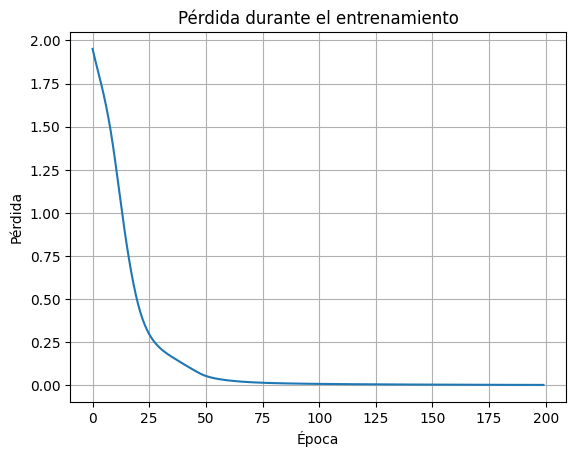

In [15]:
# Gráfica de la pérdida
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")
plt.grid(True)
plt.show()

In [32]:
# Inference
input_test = one_hot_encode(input_seq, len(vocab))
hidden = model.init_hidden()
output, hidden_states = model(input_test, hidden)

predicted_idxs = torch.argmax(output.squeeze(1), dim=1)
predicted_words = [idx2word[idx.item()] for idx in predicted_idxs]

print("Frase original:  ", words)
print("Predicciones:    ", predicted_words)

Frase original:   ['i', 'like', 'to', 'eat', 'pizza', 'and', 'i', 'like', 'to', 'eat', 'pasta']
Predicciones:     ['like', 'to', 'eat', 'pizza', 'and', 'i', 'like', 'to', 'eat', 'pasta']


In [19]:
from tabulate import tabulate

# Emparejamos palabra real y palabra predicha por índice
table_data = []

for i in range(len(predicted_words)):
    table_data.append([i, words[i], predicted_words[i]])

# Mostrar la tabla
print(tabulate(table_data, headers=["Índice", "Palabra Original", "Palabra Predicha"], tablefmt="fancy_grid"))

╒══════════╤════════════════════╤════════════════════╕
│   Índice │ Palabra Original   │ Palabra Predicha   │
╞══════════╪════════════════════╪════════════════════╡
│        0 │ i                  │ like               │
├──────────┼────────────────────┼────────────────────┤
│        1 │ like               │ to                 │
├──────────┼────────────────────┼────────────────────┤
│        2 │ to                 │ eat                │
├──────────┼────────────────────┼────────────────────┤
│        3 │ eat                │ pizza              │
├──────────┼────────────────────┼────────────────────┤
│        4 │ pizza              │ and                │
├──────────┼────────────────────┼────────────────────┤
│        5 │ and                │ i                  │
├──────────┼────────────────────┼────────────────────┤
│        6 │ i                  │ like               │
├──────────┼────────────────────┼────────────────────┤
│        7 │ like               │ to                 │
├─────────